In [59]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import polars as pl
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [8]:
# https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data?select=transactions_train.csv
raw_df = pl.read_csv(
    "../../data/transactions_train.csv",
    columns=["t_dat", "customer_id", "price"],
    try_parse_dates=True,
    # parse_dates=["InvoiceDate"]
)

raw_df.head()

t_dat,customer_id,price
date,str,f64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.050831
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.030492
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.015237
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932


In [9]:
print(f"Date range: {raw_df['t_dat'].min()} - {raw_df['t_dat'].max()}")

Date range: 2018-09-20 - 2020-09-22


In [10]:
raw_df["customer_id"].n_unique()

1362281

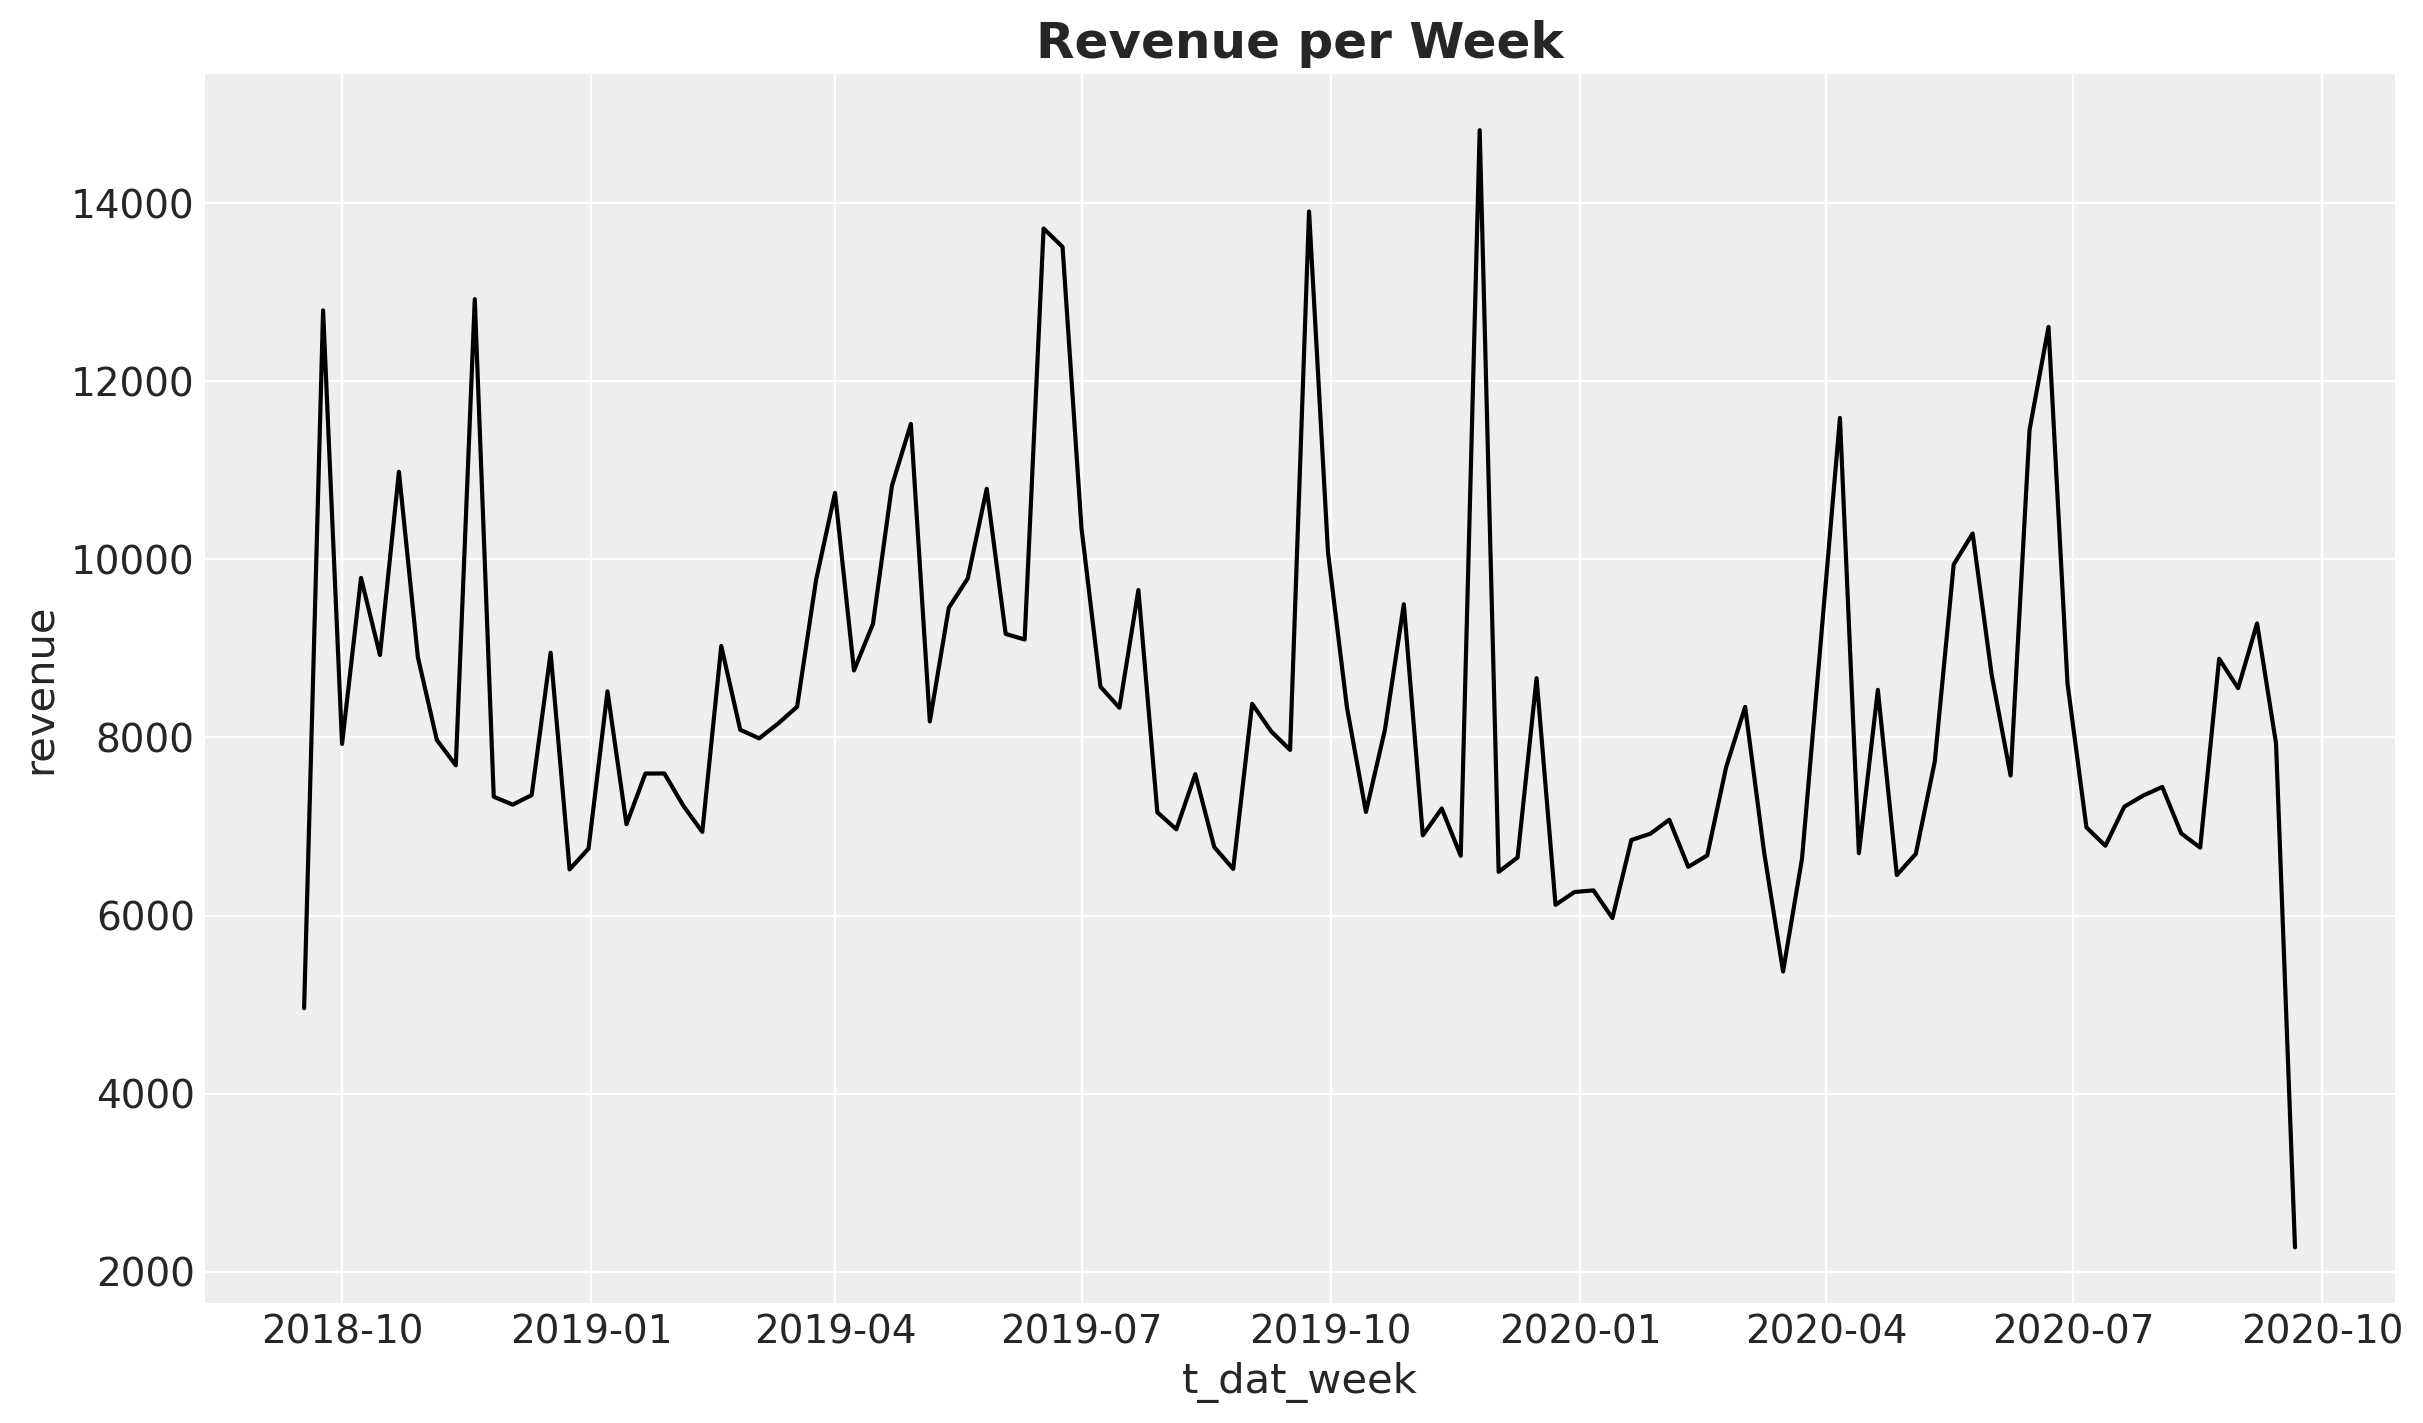

In [11]:
fig, ax = plt.subplots()
(
    raw_df.with_columns(pl.col("t_dat").dt.truncate("1w").alias("t_dat_week"))
    .group_by("t_dat_week")
    .agg(pl.col("price").sum().alias("revenue"))
    .pipe(sns.lineplot, x="t_dat_week", y="revenue", color="black", ax=ax)
)
ax.set_title("Revenue per Week", fontsize=18, fontweight="bold");

In [35]:
customers_df = (
    raw_df.rename({"t_dat": "date"})
    .with_columns(
        pl.col("date").cast(pl.Date()).dt.truncate("1mo").alias("period"),
    )
    .group_by(["period", "customer_id"])
    .agg(pl.col("price").sum().alias("revenue"))
    .with_columns(pl.col("period").min().over(["customer_id"]).alias("cohort"))
    .with_columns(
        pl.col("customer_id").unique().len().over(["cohort"]).alias("n_users")
    )
    .sort(["cohort", "customer_id", "period"])
)

customers_df.head()

period,customer_id,revenue,cohort,n_users
date,str,f64,date,u32
2018-09-01,"""0000423b00ade91418cceaf3b26c6a…",0.29139,2018-09-01,140340
2019-01-01,"""0000423b00ade91418cceaf3b26c6a…",0.033881,2018-09-01,140340
2019-04-01,"""0000423b00ade91418cceaf3b26c6a…",0.169424,2018-09-01,140340
2019-05-01,"""0000423b00ade91418cceaf3b26c6a…",0.526915,2018-09-01,140340
2019-06-01,"""0000423b00ade91418cceaf3b26c6a…",0.176136,2018-09-01,140340


In [65]:
cohort_df = (
    customers_df.group_by(["cohort", "period"])
    .agg(
        pl.col("revenue").sum(),
        pl.col("n_users").mean().cast(pl.Int64()),
        pl.col("customer_id").n_unique().cast(pl.Int64()).alias("n_active"),
    )
    .with_columns(pl.col("n_active").truediv(pl.col("n_users")).alias("retention"))
)

cohort_df.head()

cohort,period,revenue,n_users,n_active,retention
date,date,f64,i64,i64,f64
2019-03-01,2019-03-01,6361.708288,51185,51185,1.0
2018-09-01,2019-04-01,11265.87539,140340,55296,0.394015
2020-02-01,2020-09-01,241.871424,25060,1935,0.077215
2019-07-01,2019-10-01,587.434593,43374,5243,0.120879
2018-12-01,2019-02-01,1863.542525,89944,16636,0.18496


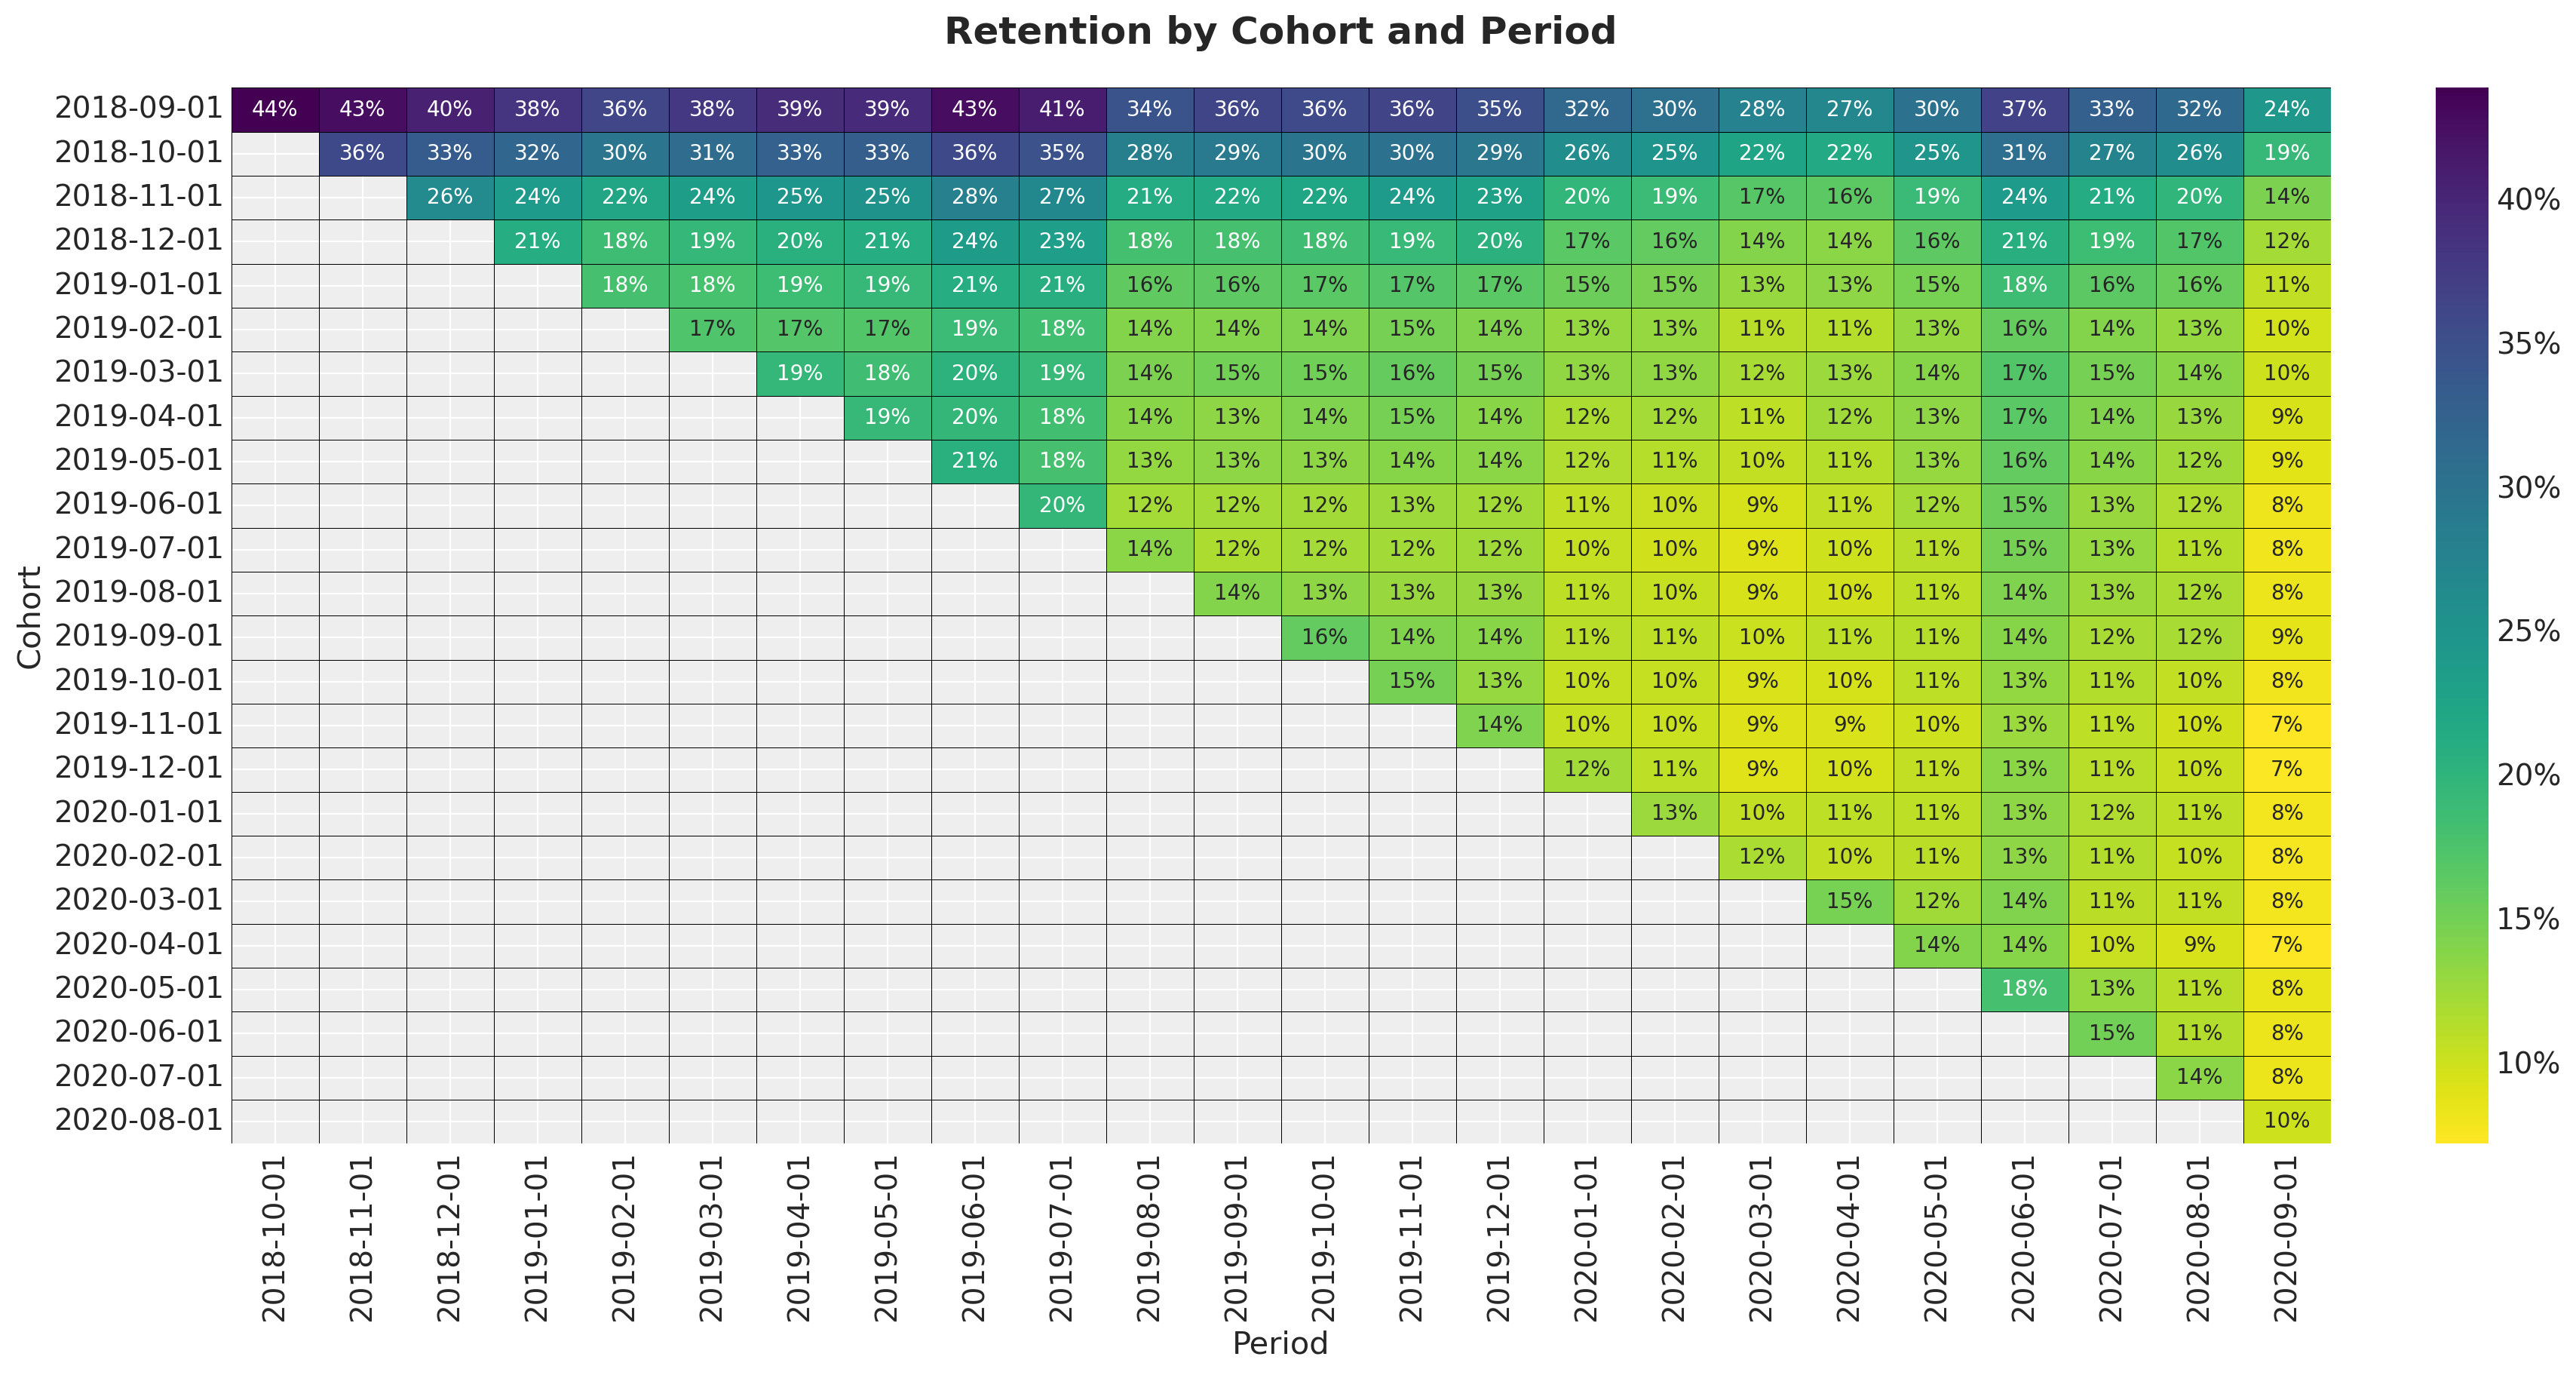

In [69]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    cohort_df.filter(pl.col("cohort").eq(pl.col("period")).not_())
    .sort(["cohort", "period"])
    .with_columns(
        pl.col("cohort").dt.strftime("%Y-%m-%d"),
    )
    .pivot(
        on="period",
        index="cohort",
        values=["retention"],
    )
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:0.0%}")},
        ax=ax,
    )
)

ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Retention by Cohort and Period", fontsize=18, fontweight="bold", y=1.03);

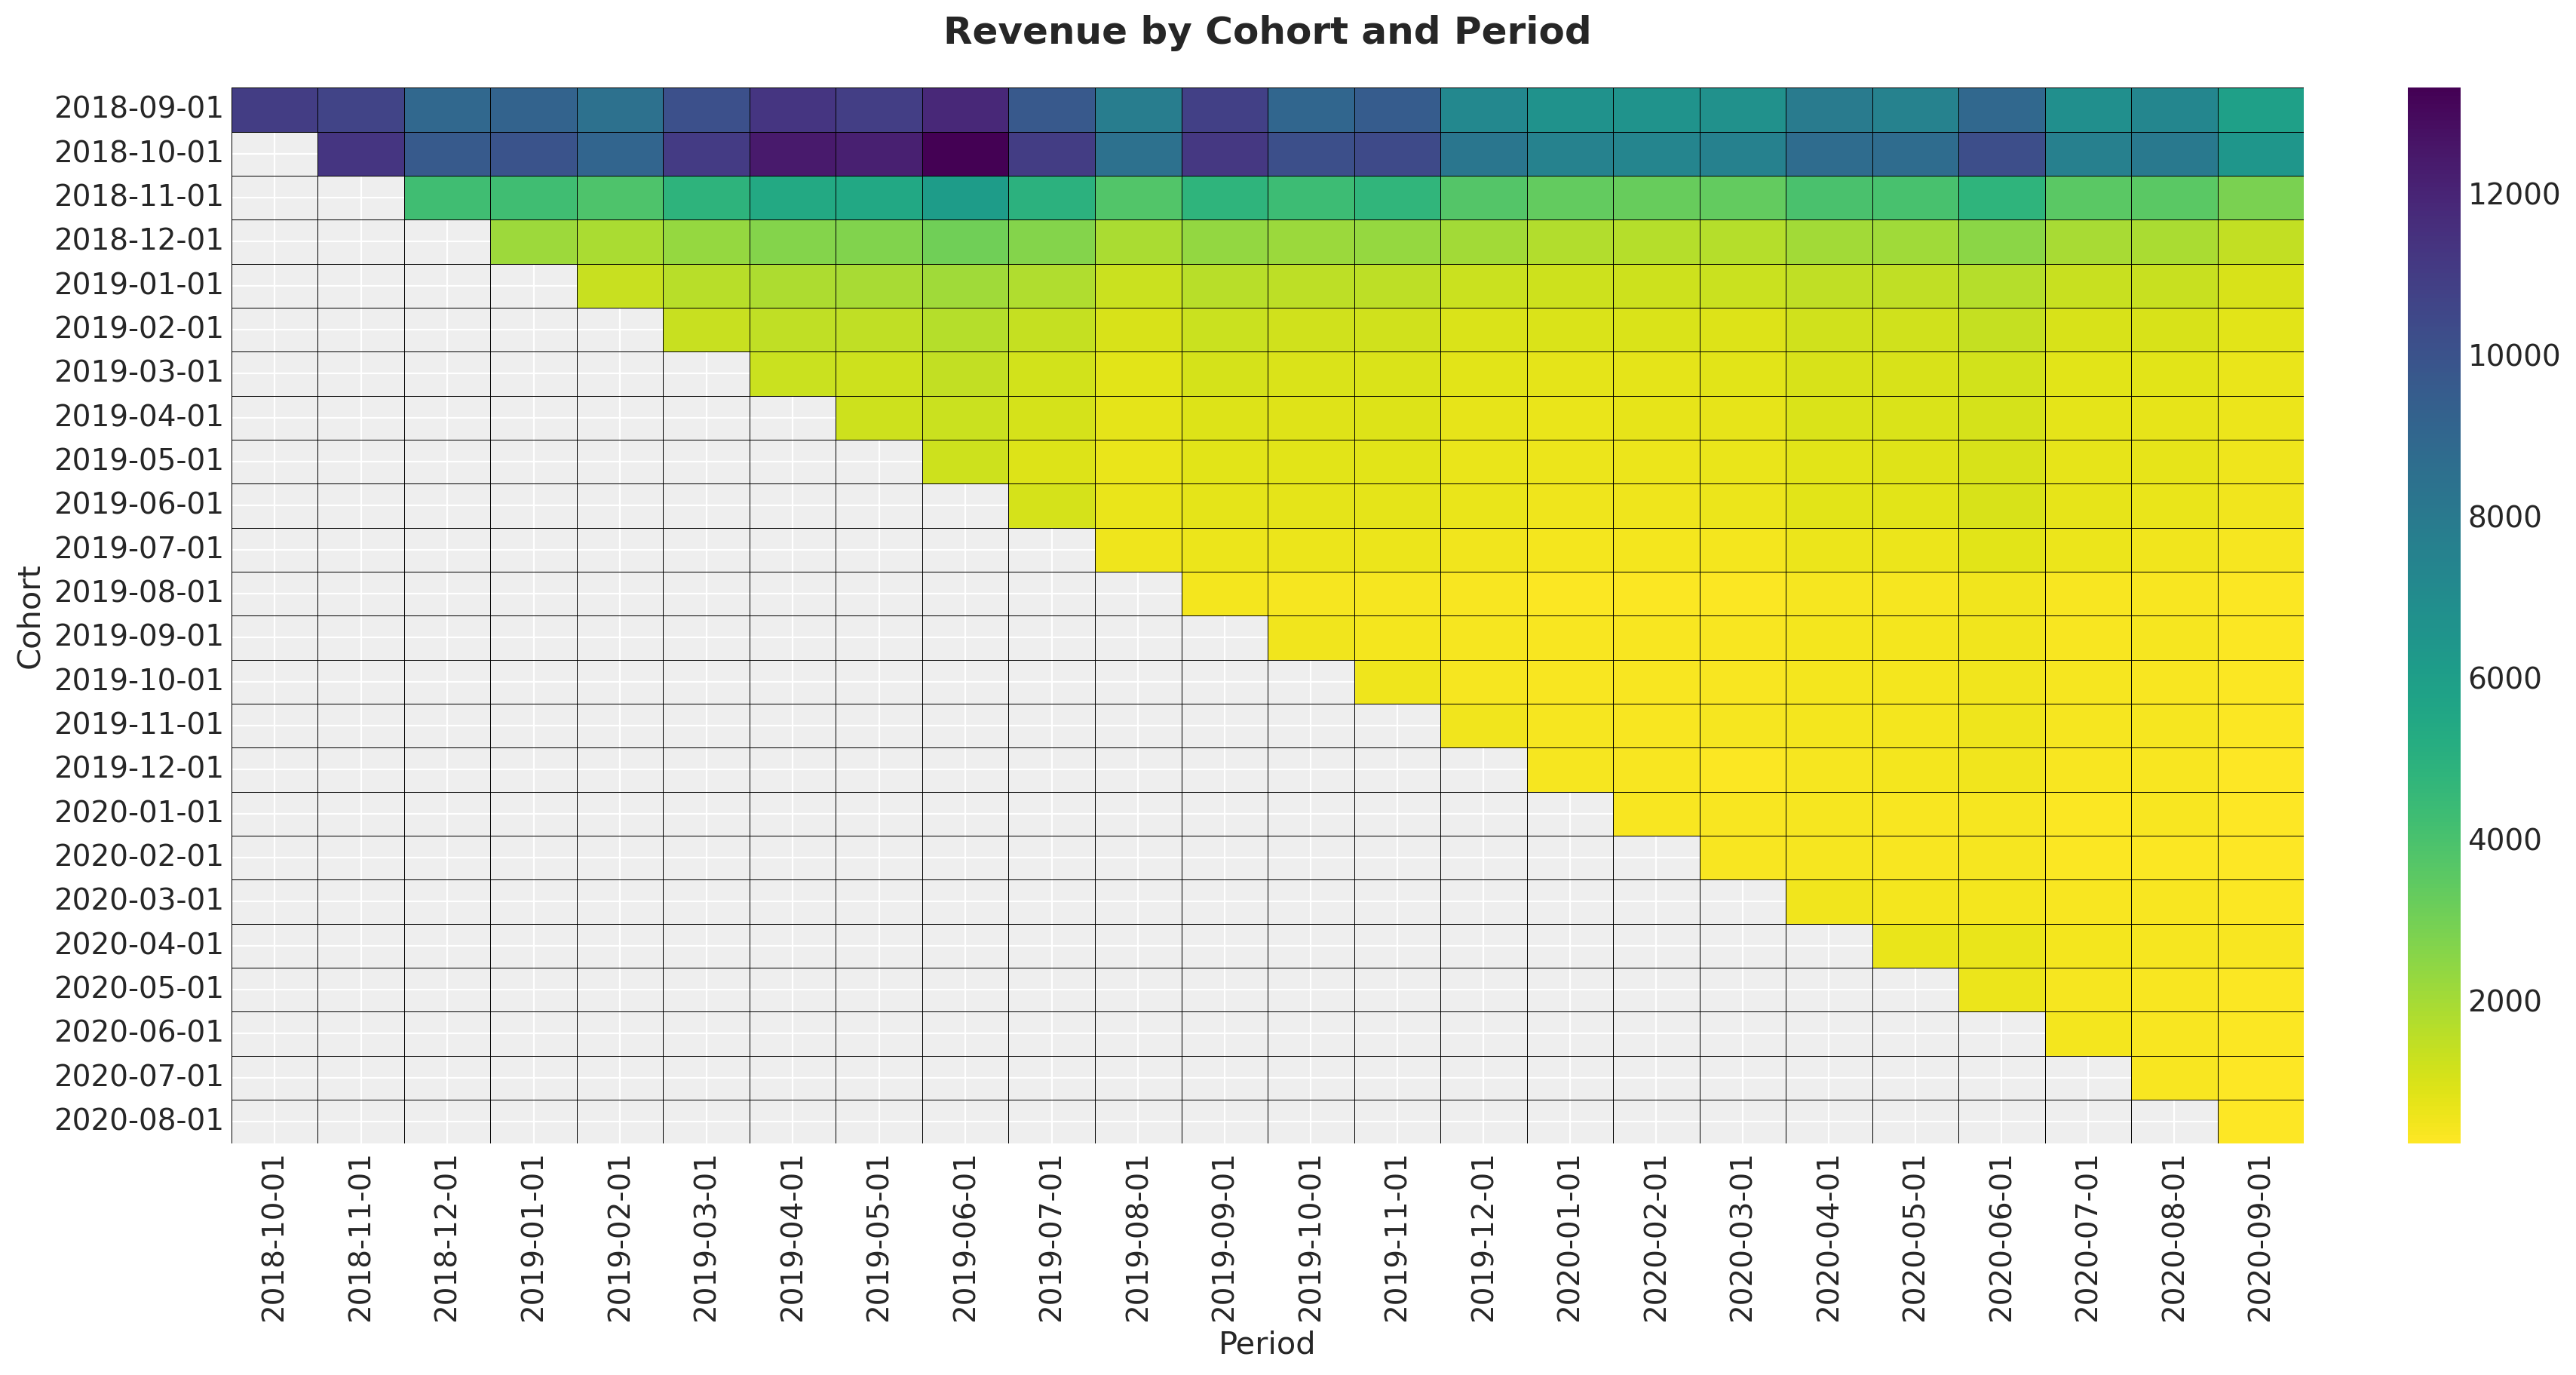

In [ ]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    cohort_df.filter(pl.col("cohort").eq(pl.col("period")).not_())
    .sort(["cohort", "period"])
    .with_columns(
        pl.col("cohort").dt.strftime("%Y-%m-%d"),
    )
    .pivot(
        on="period",
        index="cohort",
        values=["revenue"],
    )
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=False,
        # cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:0.0%}")},
        ax=ax,
    )
)

ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Revenue by Cohort and Period", fontsize=18, fontweight="bold", y=1.03);

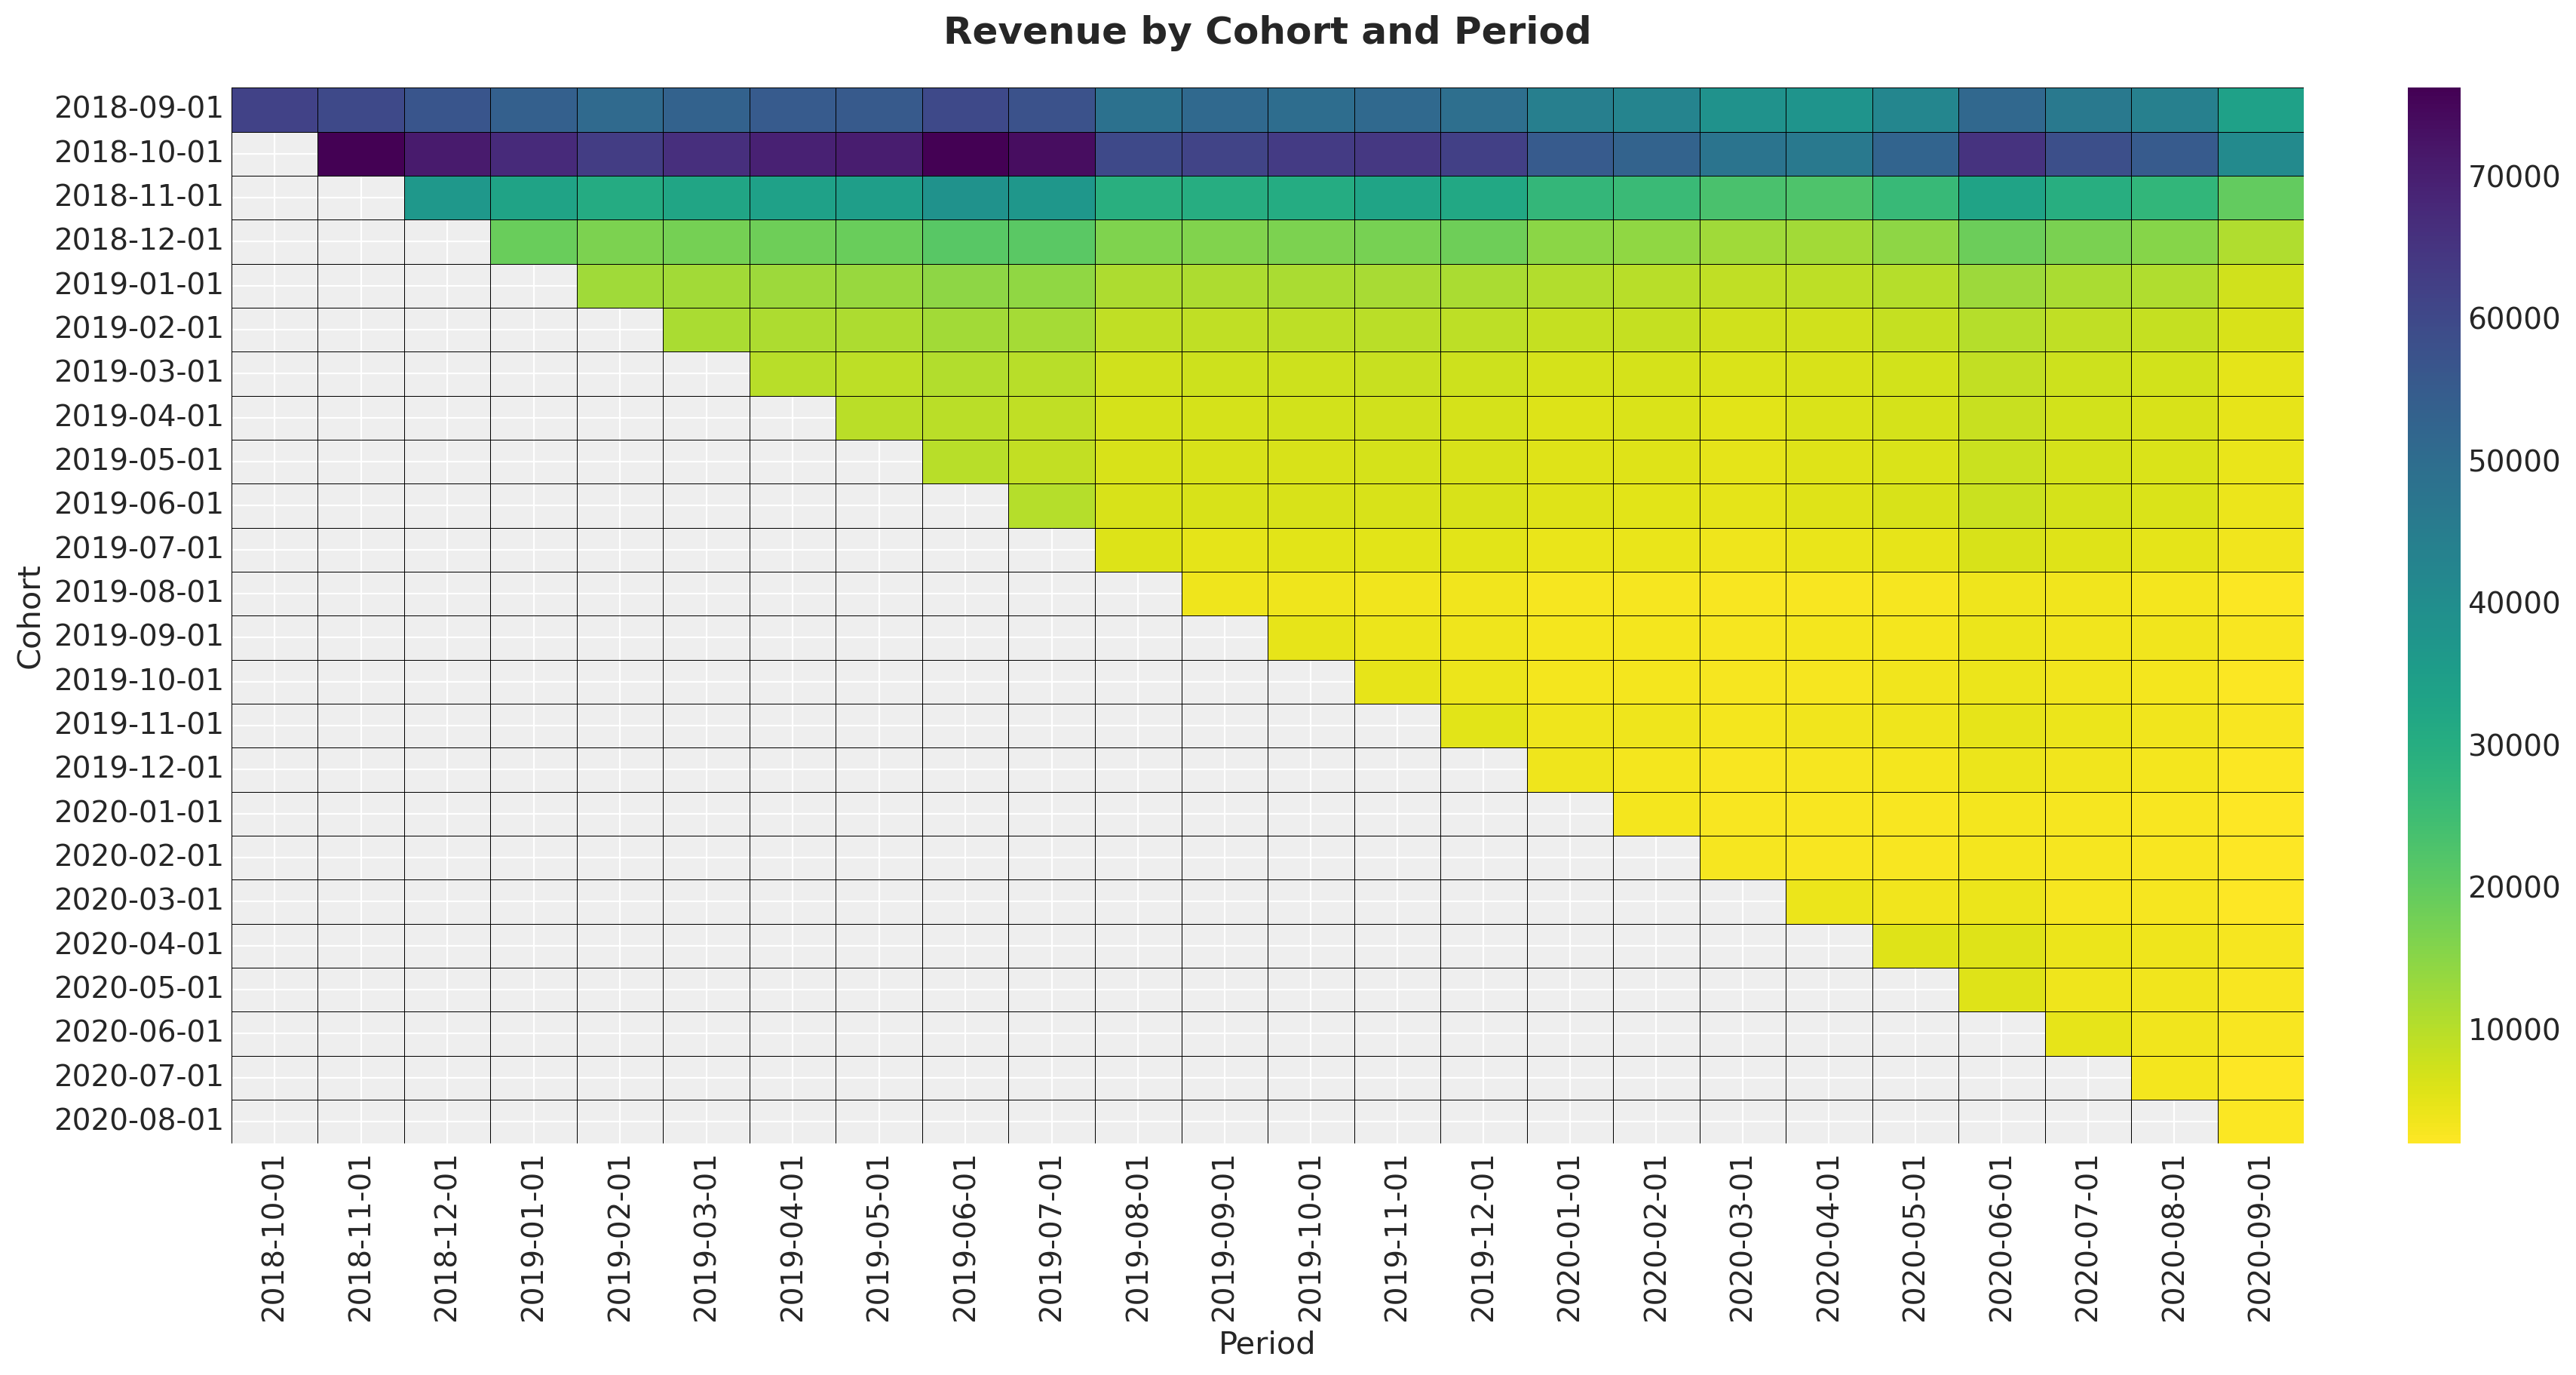

In [73]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    cohort_df.filter(pl.col("cohort").eq(pl.col("period")).not_())
    .sort(["cohort", "period"])
    .with_columns(
        pl.col("cohort").dt.strftime("%Y-%m-%d"),
    )
    .pivot(
        on="period",
        index="cohort",
        values=["n_active"],
    )
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=False,
        # cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:0.0%}")},
        ax=ax,
    )
)

ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Revenue by Cohort and Period", fontsize=18, fontweight="bold", y=1.03);